In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras_preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# Load the Dataset

In [ ]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

# Now we create the dataframe



In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


* Now we map the gender label for a better display in the graphs

In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

# Exploratory Data Analysis

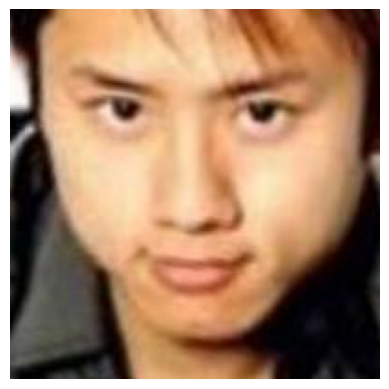

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

* Display of the first image in the dataset

* You may resize the image to a uniform width and height for easier processing

* In this project we will resize all images to 128 x 128 due to limited resources

<AxesSubplot:xlabel='age', ylabel='Density'>

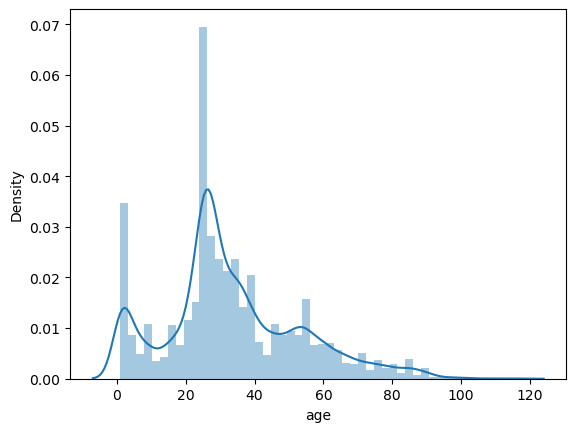

In [ ]:
sns.distplot(df['age'])

* Distplot of the age attribute

* The majority are in between ages 25 to 30 years old.

* You may convert this distribution into a scaled format using Standard Scalar (or) Min Max Normalization



<AxesSubplot:ylabel='count'>

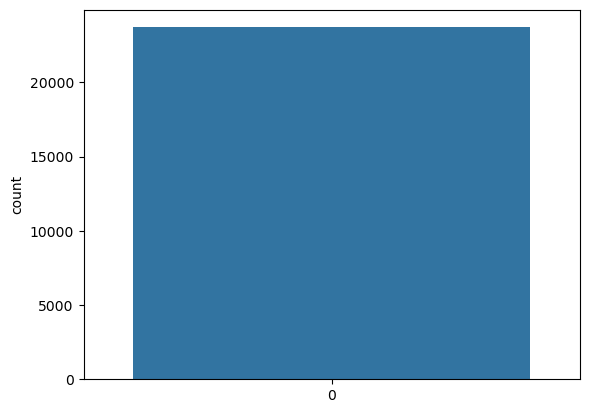

In [ ]:
sns.countplot(df['gender'])

* Visualization of the gender attribute and it's in uniform distribution



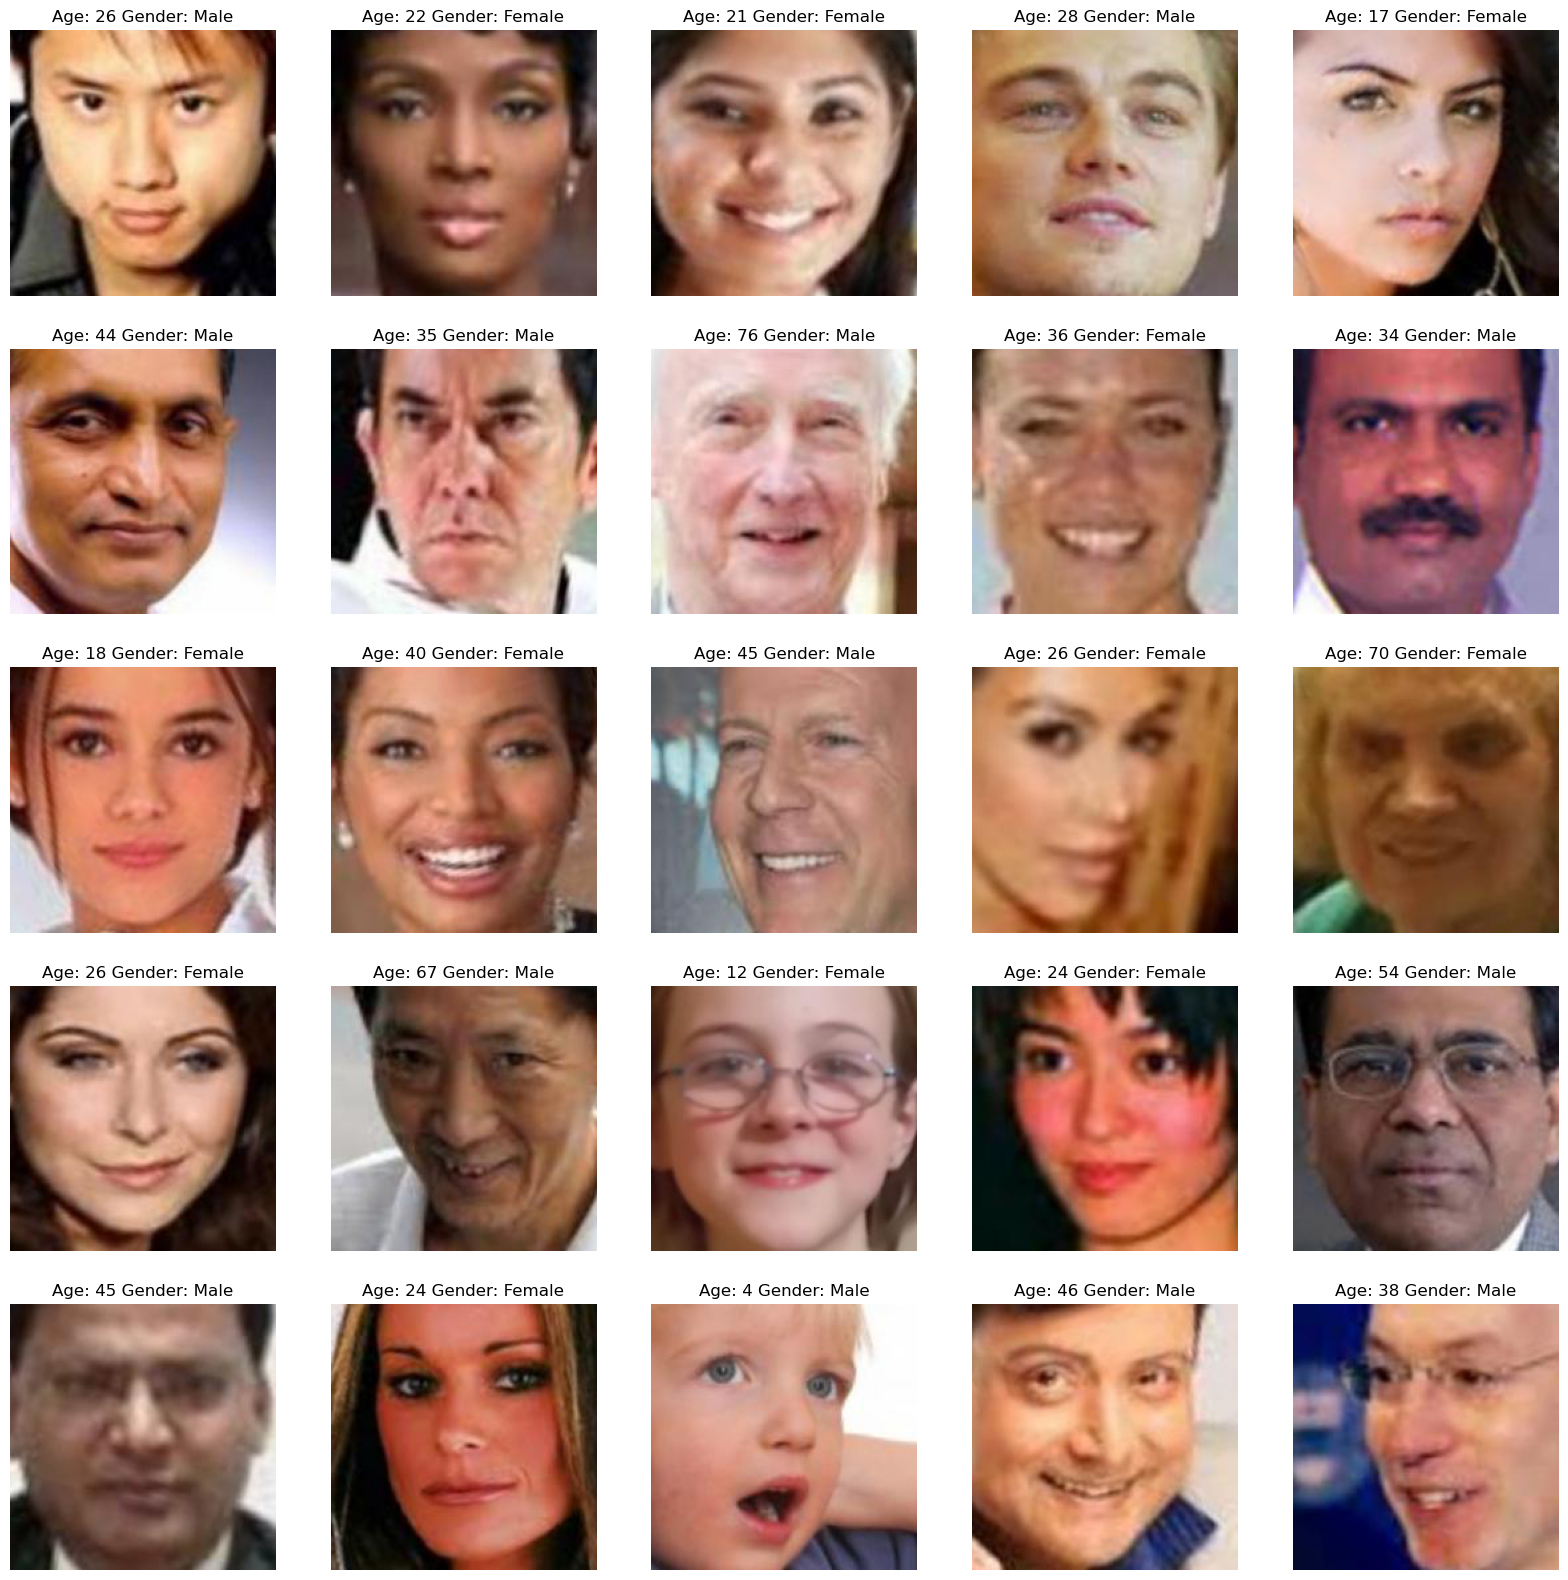

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

* Display of 25 random images with different genders and ages

* You may shuffle the data for different result

* Different saturation and qualities can be observed among the images



# Feature Extraction


* Now we define the feature extraction function



In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

* Image reshaped is defined and in grayscale for quicker processing



# Now let us test the feature extraction



In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

* Features extracted from the image data

In [ ]:
# normalize the images
X = X/255.0

* All images normalized from a range of 1 to 255 into 0 to 1

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

* Conversion of gender and age into a numpy array



In [ ]:
input_shape = (128, 128, 1)

* Configuration of input shape of the images into a fixed size and in grayscale

# Model Creation

* Now we proceed to the model creation

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

* Dropout() - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

* activation='sigmoid' - used for binary classification

* optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

* loss='binary_crossentropy' - loss function for binary outputs



# Plot the Model.

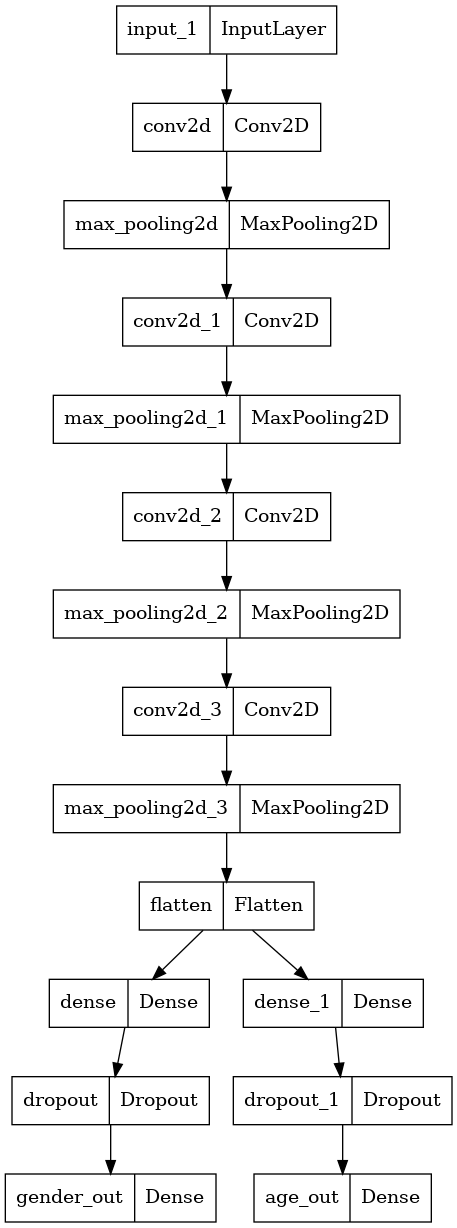

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

# Now we train the Model.

In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 17s 18ms/step - loss: 15.9486 - gender_out_loss: 0.6700 - age_out_loss: 15.2786 - gender_out_accuracy: 0.5773 - age_out_accuracy: 0.0473 - val_loss: 12.3529 - val_gender_out_loss: 0.5543 - val_age_out_loss: 11.7986 - val_gender_out_accuracy: 0.7147 - val_age_out_accuracy: 0.0392
Epoch 2/30
593/593 [==============================] - 10s 16ms/step - loss: 11.4375 - gender_out_loss: 0.4772 - age_out_loss: 10.9603 - gender_out_accuracy: 0.7727 - age_out_accuracy: 0.0301 - val_loss: 10.9722 - val_gender_out_loss: 0.4088 - val_age_out_loss: 10.5633 - val_gender_out_accuracy: 0.8203 - val_age_out_accuracy: 0.0232
Epoch 3/30
593/593 [==============================] - 10s 16ms/step - loss: 9.9907 - gender_out_loss: 0.4054 - age_out_loss: 9.5853 - gender_out_accuracy: 0.8128 - age_out_accuracy: 0.0233 - val_loss: 8.8655 - val_gender_out_loss: 0.3556 - val_age_out_loss: 8.5099 - val_gender_out_accuracy: 0.8423 - val_age_out_accuracy: 0.0108
Ep

* Set the no. of epochs and batch size according to the hardware specifications

* Training accuracy and validation accuracy increases each iteration

* Training loss and validation loss decreases each iteration

# Plot the Results

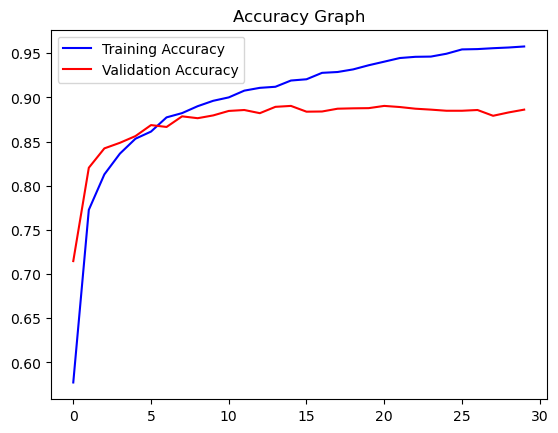

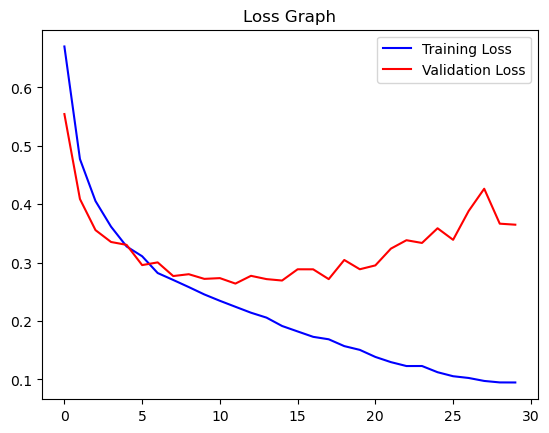

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

* Gender Accuracy: 90.00 

* Age MAE: 6.5

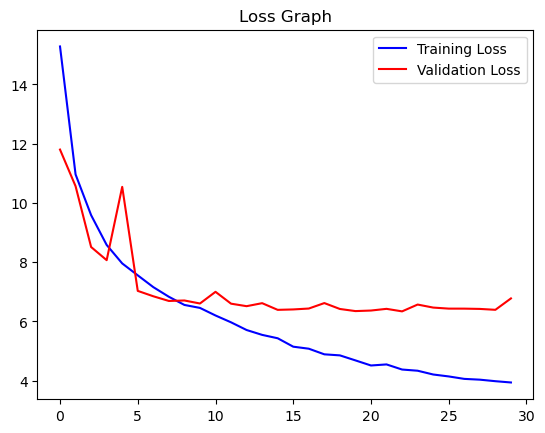

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Female Original Age: 3
1/1 [==============================] - 0s 161ms/step
Predicted Gender: Female Predicted Age: 2


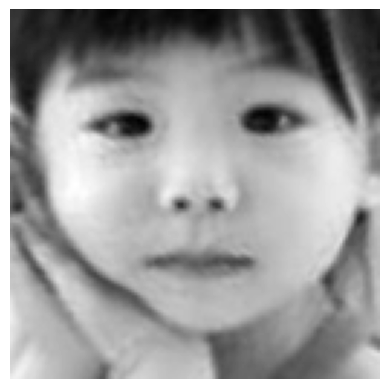

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 28
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: 28


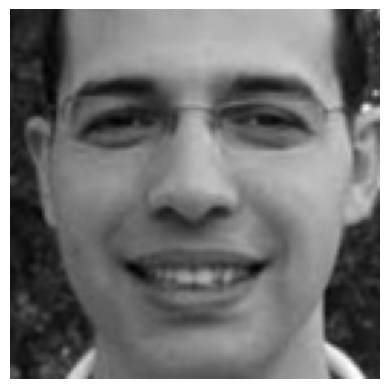

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 42
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: 37


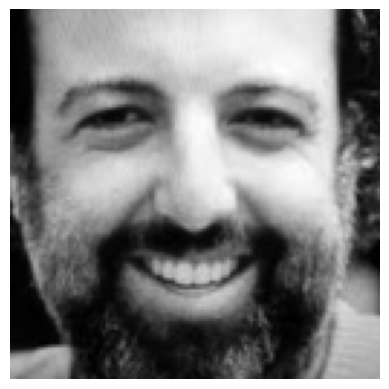

In [ ]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 18
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: 18


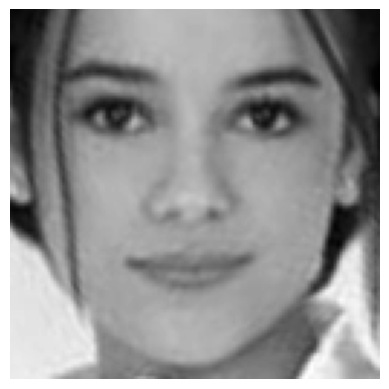

In [ ]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
model.save("my_model.h5")